# Titanic Survival Analysis

In this analysis, we will be looking at the different factors that could have affected the survival rate of the passengers of the Titanic.

### The questions I'll be answering are all related to whether a factor affected or not the survival rate:

* Did gender have an impact on the survival rate?
* Did children have higher survival rate than adults?
* Did the Passenger class (1st, 2nd, 3rd) had any effect?
* Did the unwritten law of Women and Children First (WCF) applied?
* Did having family on board made any difference?
* Did where they embarked affected their survival rate?

### Methodology:

To answer this questions I'll be analyzing the dataset provided by Udacity in which we have records for 891 passengers, different factors, such as gender, age, fare, etc.
I'll use various Chi-square tests on many different factors to test if it statistically affected or not the survival rate.

## Data Wrangling

The code below will import the data from the provided csv, rename a few columns and data to more appropriate names, so the analysis can flow no intervention afterwards.
And print the data so we can take a look at the final dataset.

In [48]:
#First, we start by importing the necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
#Now we import the data as a pandas DataFrame

data = pd.DataFrame.from_csv('./titanic-data.csv')
#rename columns with more appropriate names, so the functions will be able to work automatically
data.rename(columns={'Pclass' : 'Passenger Class', 'Sex' : 'Gender'}, inplace=True)
#rename the passenger class values
def label_class(row):
    if row['Passenger Class'] == 1:
        return '1st'    
    if row['Passenger Class'] == 2:
        return '2nd'
    if row['Passenger Class'] == 3:
        return '3rd'
    else:
        return np.Nan
data['Passenger Class'] = data.apply(lambda row: label_class(row), axis=1)
#rename the cities they embarked to their full names
def label_city(row):
    if row['Embarked'] == 'C':
        return 'Cherbourg'    
    if row['Embarked'] == 'Q':
        return 'Queenstown'
    if row['Embarked'] == 'S':
        return 'Southampton'
    else:
        return np.NaN
data['Embarked'] = data.apply(lambda row: label_city(row), axis=1)
#create a new column labeling each passenger as an Adult or a Child, based on age (14 and below are considered
#children), with NaN for missing values, so we can use the .dropna method when cleaning the data for analysis
def label_adult_child(row):
    if row['Age'] < 14:
        return 'Child'
    if row['Age'] >= 14:
        return 'Adult'
    else:
        return np.NaN
data['Adult or Child'] = data.apply(lambda row: label_adult_child(row), axis=1)
#create a new column telling if they had family on board, be it siblings, spouses, parents, or children, 
#with NaN for missing values
def family(row):
    if row['SibSp'] != 0 or row['Parch'] != 0:
        return 'Yes'
    if row['SibSp'] == 0 and row['Parch'] == 0:
        return 'No'
    else:
        return np.NaN
data['Family'] = data.apply(lambda row: family(row), axis=1)
data

,Survived,Passenger Class,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Adult or Child,Family
PassengerId,,,,,,,,,,,,,
1,0,3rd,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Adult,Yes
2,1,1st,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,Adult,Yes
3,1,3rd,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Adult,No
4,1,1st,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,Southampton,Adult,Yes
5,0,3rd,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,Southampton,Adult,No
6,0,3rd,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Queenstown,NaN,No
7,0,1st,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,Southampton,Adult,No
8,0,3rd,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,Southampton,Child,Yes
9,1,3rd,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,Southampton,Adult,Yes


## Function definitions

Now we define a few functions the will streamline the analysis process.

In [50]:
def values_for_plot(dataset, interest):
    """
    This function takes 2 arguments, the DataFrame and the interest (column of the DataFrame we will be looking into),
    and returns 5 variables:
    observed(list): values observed in the dataset, alternating between survived and died for each different response
    expected(list): the expected values for each different response, alternating the same way as 'observed'
    total: the total number of passengers in the data subset
    interest(str): returns the interest argument (used for automatic plotting and analysis)
    labels(list): a list of all the unique responses (used for automatic plotting and analysis)
    
    The idea behind this function is to prepare the values for the next functions.
    """
    
    data = dataset[['Survived', interest]].dropna() #drop rows with NaN values
    survivalRate = data['Survived'].value_counts()[1]/ data['Survived'].count() #Computes the survival rate for the
                                                                                #subset being analysed
    labels = sorted(data[interest].unique().tolist()) #Gather a list of unique responses
    groupByInterest = data.groupby(interest).sum() #Create a subset of the passengers who survived and sums them up
    observed = []
    expected = []
    total = []
    for item in labels:
        #iterates between all the unique responses, computes the values and appends it to the previously created lists
        totalValue = data[interest][data[interest] == item].count()
        observedValue = groupByInterest['Survived'][item]
        expectedValue = totalValue*survivalRate
        observedValue2 = totalValue - observedValue
        expectedValue2 = totalValue - expectedValue
        observed.append(observedValue)
        observed.append(observedValue2)
        expected.append(expectedValue)
        expected.append(expectedValue2)
        total.append(totalValue)
    return observed, expected, total, interest, labels
                    


In [51]:
def plot_survival(observed, expected, total, interest, labels, title=None):
    """
    This function takes 6 arguments, 5 of them already explained in the function above and a 6th, optional, to
    customize the title, and plots a nice grouped bar chart,
    """
    if title == None: 
        title = 'Survival rate by ' + interest
    else:
        title = 'Survival rate by ' + title
    survivalRate1 = np.array(observed[::2])*100/total #these calculations use slicing to alternate between survived
    survivalRate2 = np.array(expected[::2])*100/total #and died values, using only the former to calculate the rates
    numberOfBins = len(survivalRate1)
    ind = np.arange(numberOfBins) #position of the bars
    width = 0.35 #width of the bars
    fig, ax = plt.subplots() #create the figure and axes objects
    plot1 = ax.bar(ind, survivalRate1, width, color='b') #plot first bars (blue), observed survival rates
    plot2 = ax.bar(ind+width, survivalRate2, width, color='c') #plots second bars (cyan), expected survival rates
    ax.legend((plot1[0], plot2[0]), ('Observed', 'Expected')) #legend
    ax.set_title(title) #title
    ax.set_ylabel('Survival Rate (%)') #y-axis label
    ax.set_xticks(ind + width / 2) #sets the bar groups
    ax.set_xticklabels(labels) #labels each bar group
    """
    The following for loops adds a label of the values above each bar.
    """    
    for value in plot1: #adds labels with each value to the bars
        height = value.get_height()
        ax.text(value.get_x() + value.get_width()/2., 1.01*height,
                '%d' % int(height) + ' %',
                ha='center', va='bottom')
    for value in plot2: #adds labels with each value to the bars
        height = value.get_height()
        ax.text(value.get_x() + value.get_width()/2., 1.01*height,
                '%d' % int(height) + ' %',
                ha='center', va='bottom')
    plt.show()

In [52]:
def plot_frequency(data, interest, title=None):
    """
    This function takes 2 arguments, the DataFrame and the interest (column of the DataFrame we will be looking into),
    and returns a chart of the frequency per response.
    The third, optional, argument customizes the title.
    """
    if title == None: 
        title = interest
    labels = sorted(data[interest].dropna().unique().tolist()) #list of unique responses
    frequency = []
    for item in labels:
        freq = data.loc[data[interest] == item]['Name'].count()
        frequency.append(freq) #appends the frequency for each response
    total = np.array(frequency).sum()
    numberOfBins = len(frequency)
    ind = np.arange(numberOfBins) #positioning of the bars
    width = 0.5 #width of the bars
    fig, ax = plt.subplots() #creates of the figure and axes objects
    plot = ax.bar(ind+width/2, frequency, width)
    ax.set_title(title)
    ax.set_ylabel(interest) #y-axis label
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)
    for value in plot: #adds labels with each value to the bars
        height = value.get_height()
        ax.text(value.get_x() + value.get_width()/2., 1.01*height,
                '%d' % int(height) + ' ({:2.2f}%)'.format(float(int(height)/total)*100),
                ha='center', va='bottom')

In [53]:
def frequency_table(data, interest):
    """
    This function takes 2 arguments, the DataFrame and the interest (column of the DataFrame we will be looking into),
    and returns a frequency table (to be used in chi square tests) and a dataframe (to be printed).
    """
    observed, expected, total, interest, labels = values_for_plot(data, interest)
    table = []
    table.append(observed[::2])
    table.append(observed[1::2])
    df = pd.DataFrame(table, columns=labels)
    df.rename(index={0: 'Survived', 1: 'Died'}, inplace=True)
    return table, df

In [56]:
def chi2test(data, interest):
    """
    This function takes 2 arguments, the DataFrame and the interest (column of the DataFrame we will be looking into),
    and prints the results of a complete Chi Square test, be it a Test for Independence or a Goodness-of-fit test, with
    Cramer's V or Phi statistics respectively.
    """
    
    table, dframe = frequency_table(data, interest)
    x2value, pvalue, df, expected = chi2_contingency(table)
    n = len(data[interest].dropna())
    columns = len(data[interest].dropna().unique().tolist())
    kminus1 = min(len(table), columns) - 1 #always 1, because the rows are always 2 for my tests, so Cramer's V 
                                           #and phi tests always returns the same value
    cramersphi = np.sqrt(x2value/(n*kminus1))
    if columns == 2:
        return print('''Chi Square Goodness-of-fit
    
Chi Square Value: {}
p-value: {}
Degrees of Freedom: {}
Phi: {}'''.format(x2value, pvalue, df, cramersphi))
    if columns > 2:
        return print('''Chi Square Test for Independence
    
Chi Square Value: {}
p-value: {}
Degrees of Freedom: {}
Cramér's V: {}'''.format(x2value, pvalue, df, cramersphi))

## Data Exploration

Having already prepared the data and defined the necessary functions, the exploration can begin.

The flow is simple, we start with a question proposed in the beginning and look into the data to provide answers.

### Data Summary

Let's plot a few charts to have a general idea of the data we will be working with:

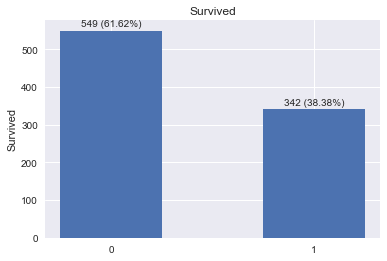

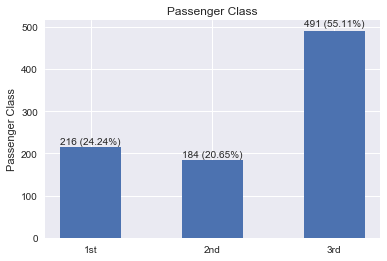

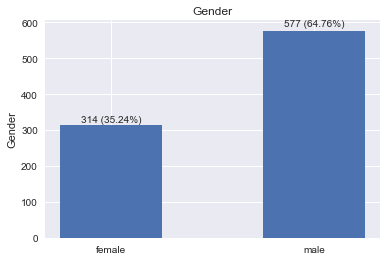

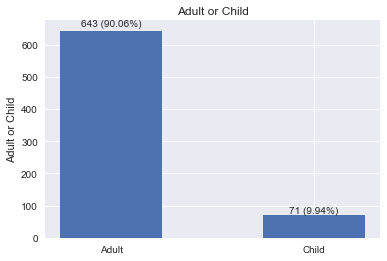

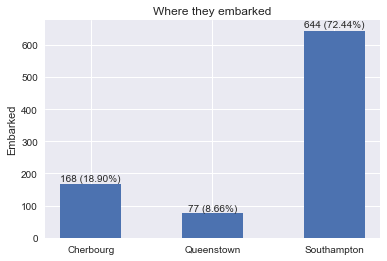

In [57]:
plot_frequency(data, 'Survived')
plot_frequency(data, 'Passenger Class')
plot_frequency(data, 'Gender')
plot_frequency(data, 'Adult or Child')
plot_frequency(data, 'Embarked', 'Where they embarked')

With these charts, we can have a general idea of the data:
* Most people on board died (61.62%), and the overall survival rate is 38.38%
* They were mostly using 3rd class accommodations
* 64.76% were male
* Only 9.94% were children (14 years old or younger)
* And almost 3/4 of them (72.44%) embarked on the Southampton port
Interesting data, but it gets us nowhere in analyzing which variables led to statistic relevant advantages in survival, so let' dive deeper!

## Data Analysis

To answer the questions proposed on the beginning, we will need to write some hypotheses (H<sub>o</sub>: Null hypothesis; H<sub>a</sub>: Alternative hypothesis), have "Survival rate plots" of each independent variable, and compute the relevant statistics, so our conclusions can be supported.

### Did gender have an impact on the survival rate?

* H<sub>o</sub>: Gender did not have an impact on the survival rate. 
* H<sub>a</sub>: Gender did have an impact on the survival rate.

Alpha Level = 0.05

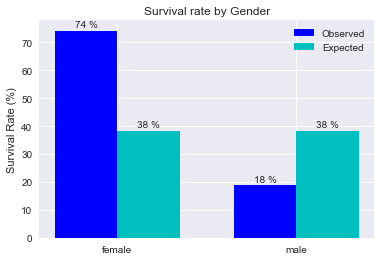

In [58]:
observed, expected, total, interest, labels = values_for_plot(data, 'Gender')
plot_survival(observed, expected, total, interest, labels)

Well, judging by the chart, it did! But let's not get ahead of ourselves, we need statistics to back our hypothesis, and the test of choice is the Chi Square.
First, we need to compute our frequency table, so we can look if our data can pass the restrictions of this test, they are:

1. Avoid dependent observations
2. And if the dataset is a sample, we need 20 or more entries
3. Avoid small frequencies, must be 5 or more each

Let's start with the first one, to test this, we need to know if every row of our dataset represents a different person.
To test this, we can check if every name on the list is unique, if we find a non-unique name, we'll find the entries and use the other variables to test if they are different or not:


In [59]:
len(data)
uniqueNames = np.count_nonzero(data['Name'].unique()) #counts every unique name
numberOfRows = len(data) #the total size of our dataset
print('Number of unique names: {}\nTotal number of rows: {}'.format(uniqueNames, numberOfRows))

Number of unique names: 891
Total number of rows: 891


Every name is unique, so every entry is unique, this test doesn't need to be repeated when analyzing the other variables.

Now the second restriction:

In [60]:
numberOfRows = len(data['Gender'].dropna()) #we drop the NaN values to make sure we only count the data that is
                                            #being used in this particular analysis
print('Total number of samples (n): {}'.format(numberOfRows))

Total number of samples (n): 891


More than enough!

To solve our last restriction, we'll need to create a frequency table:

In [61]:
table, df = frequency_table(data, 'Gender')
df

,female,male
Survived,233,109
Died,81,468


Every frequency is greater than 5, and we have 2 x 2 table so we are ready for the Chi Square Goodness-of-fit test!

In [62]:
chi2test(data, 'Gender')

Chi Square Goodness-of-fit
    
Chi Square Value: 260.71702016732104
p-value: 1.1973570627755645e-58
Degrees of Freedom: 1
Phi: 0.5409359434469282


#### Conclusion: Did gender had an impact on the survival rate?

Yes, it most definitely did! Not only our chart shows a big difference between observed and expected survival rate, but out Chi Square statistic is 260.72. That means that this outcome had less than 1.197e-56 % chance of occurring at random, so we can reject the null. To further back our conclusion the Phi statistic is superior to 0.5, which indicates that gender had a large effect on survival rate:

(0.10 = small effect) (0.30 = medium effect) (0.50=large effect)


### Did childen have higher survival rate than adults?

* H<sub>o</sub>: Childen did not have a different survival rate than adults. 
* H<sub>a</sub>: Childen did have a different survival rate than adults.

Alpha Level = 0.05

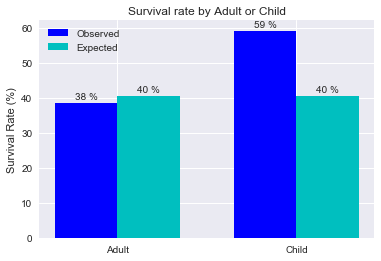

In [63]:
observed, expected, total, interest, labels = values_for_plot(data, 'Adult or Child')
plot_survival(observed, expected, total, interest, labels)

It appears so, but let's do a Chi Square Goodness-of-fit test to have a better understanding.
As we did before, we need to get the restrictions out of the way:

1. Avoid dependent observations
2. And if the dataset is a sample, we need 20 or more entries
3. Avoid small frequencies, must be 5 or more each

The first one was already solved before, so onto the second one:

In [64]:
numberOfRows = len(data['Adult or Child'].dropna()) #we drop the NaN values to make sure we only count the data that is
                                                    #being used in this particular analysis
print('Total number of samples (n): {}'.format(numberOfRows))

Total number of samples (n): 714


This time, the sample size is smaller, it is due to missing values in the 'Age' column of the original data, as we didn't have an age for some of the passengers, we have no choice but to exclude them from this part of the analysis.

And the last one:

In [65]:
table, df = frequency_table(data, 'Adult or Child')
df

,Adult,Child
Survived,248,42
Died,395,29


We have enough frequency again, more than 5, so let's proceed with the test:

In [66]:
chi2test(data, 'Adult or Child')

Chi Square Goodness-of-fit
    
Chi Square Value: 10.39675893095637
p-value: 0.0012623669263000742
Degrees of Freedom: 1
Phi: 0.12067015794365306


#### Conclusion: Did children have higher survival rate than adults?
The Chi Square test shows us that being a child did have an effect on the survival rate, with these results having less than 0.13 % chance of occurring at random, so we can reject the null, but the Phi statistic, tells that the effect is as small one:
(0.10 = small effect) (0.30 = medium effect) (0.50=large effect)

### Did the Passenger class (1st, 2nd, 3rd) had any effect?

* H<sub>o</sub>: Passenger Class did not have an impact on the survival rate. 
* H<sub>a</sub>: Passenger Class did have an impact on the survival rate.

Alpha Level = 0.05

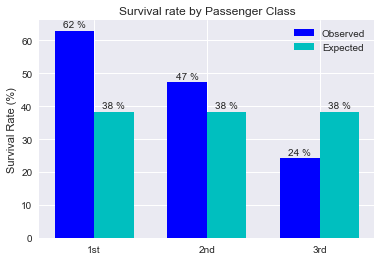

In [67]:
observed, expected, total, interest, labels = values_for_plot(data, 'Passenger Class')
plot_survival(observed, expected, total, interest, labels)

We have here some interesting results, it seems like it. Passengers from the 1st and 2nd class have a higher than average survival rate than the 3rd class.

Let's look into it with a Chi Square test, as soon as the restrictions are solved:

In [68]:
numberOfRows = len(data['Passenger Class'].dropna()) #we drop the NaN values to make sure we only count the data that is
                                                    #being used in this particular analysis
print('Total number of samples (n): {}'.format(numberOfRows))

Total number of samples (n): 891


In [69]:
table, df = frequency_table(data, 'Passenger Class')
df

,1st,2nd,3rd
Survived,136,87,119
Died,80,97,372


We're good to go! This time we have a 2 x 3 table, so let's do a Chi Square Test for Independence:

In [70]:
chi2test(data, 'Passenger Class')

Chi Square Test for Independence
    
Chi Square Value: 102.88898875696057
p-value: 4.5492517112987287e-23
Degrees of Freedom: 2
Cramér's V: 0.33981738800531175


#### Conclusion: Did the Passenger class (1st, 2nd, 3rd) had any effect?

Yes, it did. With a 102.89 Chi Square value we can conclude that the effect observed in the survival rate is not a random one (with a p-value of 4.549e-23 we can be "almost sure" of that), so we can reject the null. And the Cramér's V value of 0.34 tells us that the effect is a medium one, according to the Cohen's table for effect size:

k-1=1 (0.10 = small effect) (0.30 = medium effect) (0.50=large effect)

k-1=2 (0.07 = small effect) (0.21= medium effect) (0.35 = large effect)

k-1=3 (0.06 = small effect) (0.17 = medium effect) (0.29 = large effect)

### Did the unwritten law of Women and Children First (WCF) applied?

* H<sub>o</sub>: The WCF law did not apply (women and children had the same survival rate as men). 
* H<sub>a</sub>: The WCF law did apply (women and children had a different survival rate as men).

Alpha Level = 0.05

To answer this question, we will need to do some data wrangling, we need to create another column for our data that differentiate the passengers between man, woman and child:

In [71]:
def label_gender_child(row):
    if row['Age'] < 14:
        return 'child'
    if row['Age'] >= 14 and row['Gender'] == 'male':
        return 'male'
    if row['Age'] >= 14 and row['Gender'] == 'female':
        return 'female'
    else:
        return np.NaN
data['Child, Male or Female'] = data.apply(lambda row: label_gender_child(row), axis=1)
data

,Survived,Passenger Class,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Adult or Child,Family,"Child, Male or Female"
PassengerId,,,,,,,,,,,,,,
1,0,3rd,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Adult,Yes,male
2,1,1st,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,Adult,Yes,female
3,1,3rd,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Adult,No,female
4,1,1st,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,Southampton,Adult,Yes,female
5,0,3rd,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,Southampton,Adult,No,male
6,0,3rd,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Queenstown,NaN,No,NaN
7,0,1st,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,Southampton,Adult,No,male
8,0,3rd,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,Southampton,Child,Yes,child
9,1,3rd,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,Southampton,Adult,Yes,female


Looks good! As we already took care of all the precautions for a Chi Square tests we don't need to do it again.

So, we'll dive right in, plot a chart, and do a Chi Square Test for independence:

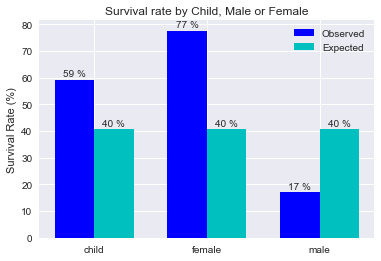

In [72]:
observed, expected, total, interest, labels = values_for_plot(data, 'Child, Male or Female')
plot_survival(observed, expected, total, interest, labels)

In [73]:
chi2test(data, 'Child, Male or Female')

Chi Square Test for Independence
    
Chi Square Value: 232.08505943213527
p-value: 4.0120808688093735e-51
Degrees of Freedom: 2
Cramér's V: 0.5701307769679934


#### Conclusion: Did the unwritten law of Women and Children First (WCF) applied?

As expected we can conclude that WCF law worked.
With about a 4.012e-49 % chance of these results not being random, so we can reject the null, and a strong effect size as per Cohen's table (Cramér's V: 0.57).

### Did having family on board made any difference?

* H<sub>o</sub>: Having family on board did not make any difference in the survival rate. 
* H<sub>a</sub>: Having family on board did make a difference in the survival rate.

Alpha Level = 0.05

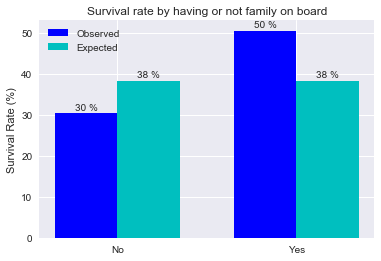

In [74]:
observed, expected, total, interest, labels = values_for_plot(data, 'Family')
plot_survival(observed, expected, total, interest, labels, 'having or not family on board')

It seems like having family on board made a difference!
Let's see if it is statistically relevant, but first let's see if we can use Chi Square:

In [75]:
numberOfRows = len(data['Family'].dropna()) #we drop the NaN values to make sure we only count the data that is
                                                    #being used in this particular analysis
print('Total number of samples (n): {}'.format(numberOfRows))

Total number of samples (n): 891


In [76]:
table, df = frequency_table(data, 'Family')
df

,No,Yes
Survived,163,179
Died,374,175


Yes, we can. So, without further delay, our Chi Square Goodness of fit test:

In [77]:
chi2test(data, 'Family')

Chi Square Goodness-of-fit
    
Chi Square Value: 36.00051446773865
p-value: 1.9726543846517113e-09
Degrees of Freedom: 1
Phi: 0.20100899932318905


#### Conclusion: Did having family on board made any difference?

It did. With a Chi Square Value of 36, and a p-value of 1.9726e-09 these values most definitely not random, so we can reject the null. 
And with a Phi statistic of 0.20 the effect size is between a small (0.10) and a medium (0.3) one.

### Did where they embarked affected their survival rate?


* H<sub>o</sub>: Where they embarked did not affect their survival rate. 
* H<sub>a</sub>: Where they embarked affected their survival rate.

Alpha Level = 0.05

This last question is highly unlikely to be true, but, as we have the data let's look into it:

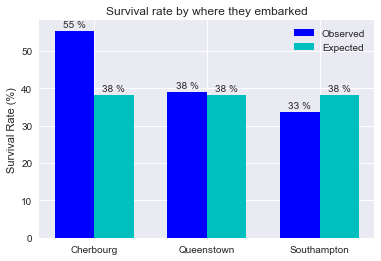

In [78]:
observed, expected, total, interest, labels = values_for_plot(data, 'Embarked')
plot_survival(observed, expected, total, interest, labels, 'where they embarked')

Whoa, not what I was expecting! We'll do a Chi Square test to see if it is statistically relevant.

Let's take the restrictions out of the way:

In [79]:
numberOfRows = len(data['Embarked'].dropna()) #we drop the NaN values to make sure we only count the data that is
                                                    #being used in this particular analysis
print('Total number of samples (n): {}'.format(numberOfRows))
table, df = frequency_table(data, 'Embarked')
df

Total number of samples (n): 889


,Cherbourg,Queenstown,Southampton
Survived,93,30,217
Died,75,47,427


Looks good, let's preceed with the Chi Square Test for Independence:

In [80]:
chi2test(data, 'Embarked')

Chi Square Test for Independence
    
Chi Square Value: 26.48914983923762
p-value: 1.769922284120912e-06
Degrees of Freedom: 2
Cramér's V: 0.17261682709984438


With these results, we can reject the null, and even say that where the passengers embarked did have a small (0.10) to moderate (0.30) effect size on whether or not they survived.

But it doesn't make sense! "Correlation doesn't mean causation"! So, let's take a closer look on the passengers who embarked on Cherbourg:

In [81]:
datac = data.loc[data['Embarked']=='Cherbourg'] #this creates a dataset of only the passengers whe embarked in Cherbourg
datac

,Survived,Passenger Class,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Adult or Child,Family,"Child, Male or Female"
PassengerId,,,,,,,,,,,,,,
2,1,1st,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,Cherbourg,Adult,Yes,female
10,1,2nd,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,Cherbourg,Adult,Yes,female
20,1,3rd,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,Cherbourg,NaN,No,NaN
27,0,3rd,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,Cherbourg,NaN,No,NaN
31,0,1st,"Uruchurtu, Don. Manuel E",male,40.00,0,0,PC 17601,27.7208,NaN,Cherbourg,Adult,No,male
32,1,1st,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,Cherbourg,NaN,Yes,NaN
35,0,1st,"Meyer, Mr. Edgar Joseph",male,28.00,1,0,PC 17604,82.1708,NaN,Cherbourg,Adult,Yes,male
37,1,3rd,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,Cherbourg,NaN,No,NaN
40,1,3rd,"Nicola-Yarred, Miss. Jamila",female,14.00,1,0,2651,11.2417,NaN,Cherbourg,Adult,Yes,female


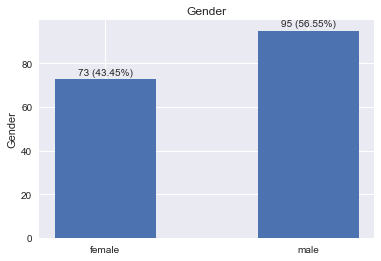

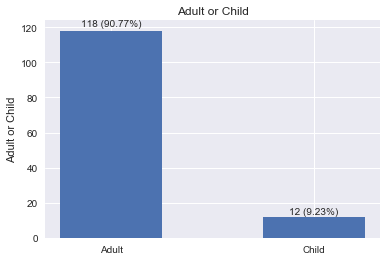

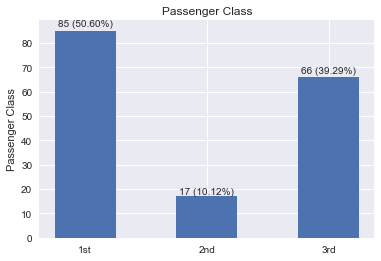

In [82]:
plot_frequency(datac, 'Gender')
plot_frequency(datac, 'Adult or Child')
plot_frequency(datac, 'Passenger Class')

#### Conclusion: Did where they embarked affected their survival rate?

Looking at these charts we can find an explanation! While the proportion of adults vs. children is almost the same as the rest of the passengers, we have a superior proportion of women (43.45% vs. 35.24%). But what most likely led to the passenger who embarked in Cherbourg to have a higher survival rate is the fact that most were 1st Class passengers (50.60% vs. 24.24%).

## References

* Udacity Data Analyst Nanodegree materials
* Udacity Intro to Inferential Statistics materials
* Statistical decision tree: http://www.muhlenberg.edu/media/contentassets/pdf/academics/psychology/stats_decision.pdf
* Effect size: http://www.real-statistics.com/chi-square-and-f-distributions/effect-size-chi-square/